In [1]:
# Gerekli temel kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import folium
from folium.plugins import MarkerCluster
import os
import glob

# Grafik ayarları
%matplotlib inline
sns.set(style="whitegrid")


In [2]:
# CSV dosyalarının bulunduğu klasör
veri_dizini = r"C:\Users\zeyne\OneDrive\Masaüstü\veri_bilimi_proje\veriler"

# Tüm CSV dosyalarını oku ve birleştir
csv_dosyalar = glob.glob(os.path.join(veri_dizini, "*.csv"))
veriler = pd.concat((pd.read_csv(dosya) for dosya in csv_dosyalar), ignore_index=True)

# İlk 5 satırı görüntüle
veriler.head()


,DATE_TIME,LATITUDE,LONGITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2024-01-01 00:00:00,41.338806,27.965698,sx7ghm,31,121,76,9
1,2024-01-01 00:00:00,41.157532,29.174194,sxkdpu,69,89,81,2
2,2024-01-01 00:00:00,41.058655,28.361206,sxk1t6,22,145,80,23
3,2024-01-01 00:00:00,40.954285,29.086304,sxk8vz,1,75,30,45
4,2024-01-01 00:00:00,41.003723,28.855591,sxk928,4,37,20,29


In [3]:
# Veri setinin genel yapısı
veriler.info()
# Eksik değer kontrolü
veriler.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19099527 entries, 0 to 19099526
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   DATE_TIME           object 
 1   LATITUDE            float64
 2   LONGITUDE           float64
 3   GEOHASH             object 
 4   MINIMUM_SPEED       int64  
 5   MAXIMUM_SPEED       int64  
 6   AVERAGE_SPEED       int64  
 7   NUMBER_OF_VEHICLES  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 1.1+ GB


DATE_TIME             0
LATITUDE              0
LONGITUDE             0
GEOHASH               0
MINIMUM_SPEED         0
MAXIMUM_SPEED         0
AVERAGE_SPEED         0
NUMBER_OF_VEHICLES    0
dtype: int64

In [4]:
# Tüm satırların sayısal değerlere sahip olup olmadığının kontrolü
veriler = veriler.dropna()  
veriler = veriler.reset_index(drop=True)


In [5]:
veriler.columns


Index(['DATE_TIME', 'LATITUDE', 'LONGITUDE', 'GEOHASH', 'MINIMUM_SPEED',
       'MAXIMUM_SPEED', 'AVERAGE_SPEED', 'NUMBER_OF_VEHICLES'],
      dtype='object')

In [6]:
# DATE_TIME sütununu datetime formatına çeviriyoruz
veriler['DATE_TIME'] = pd.to_datetime(veriler['DATE_TIME'])

# Zaman bileşenlerini çıkartıyoruz
veriler['saat'] = veriler['DATE_TIME'].dt.hour
veriler['gun'] = veriler['DATE_TIME'].dt.day
veriler['haftaici'] = veriler['DATE_TIME'].dt.weekday < 5  # Pazartesi–Cuma: True


In [7]:
# Boolean olan haftaici özelliğini sayısala çevirelim (True→1, False→0)
veriler['haftaici'] = veriler['haftaici'].astype(int)

# Kullanılacak özellikleri seçiyoruz
ozellikler = veriler[['saat', 'haftaici', 'LATITUDE', 'LONGITUDE',
                      'AVERAGE_SPEED', 'MINIMUM_SPEED', 'MAXIMUM_SPEED',
                      'NUMBER_OF_VEHICLES']]


In [8]:
#Ölçekleme (Normalizasyon)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(ozellikler)


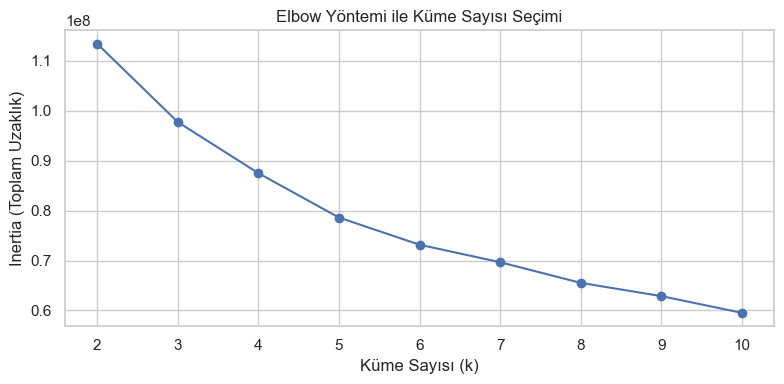

In [12]:
# K Değerini belirleme: Elbow Yöntemi
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Yöntemi ile Küme Sayısı Seçimi")
plt.xlabel("Küme Sayısı (k)")
plt.ylabel("Inertia (Toplam Uzaklık)")
plt.xticks(k_values)
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
from sklearn.cluster import KMeans

# K-Means modelini 4 küme ile kuruyoruz
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Küme etiketlerini veri setine ekliyoruz
veriler['cluster'] = clusters


In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA ile 2 boyuta indirgeme
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

# PCA sonuçlarını ayrı dataframe olarak saklıyoruz
veriler['PCA1'] = pca_result[:, 0]
veriler['PCA2'] = pca_result[:, 1]

# Grafik çizimi
plt.figure(figsize=(10, 7))
plt.scatter(veriler['PCA1'], veriler['PCA2'], c=veriler['cluster'], cmap='viridis', s=5)
plt.title("PCA ile 2 Boyutlu Küme Görselleştirmesi (k=4)")
plt.xlabel("Ana Bileşen 1")
plt.ylabel("Ana Bileşen 2")
plt.colorbar(label="Küme")
plt.grid(True)
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

In [ ]:
#Yoğunluk Temelli Renk Atamasıyla Folium Haritası
import folium
# Harita merkezi
harita_merkez = [veriler['LATITUDE'].mean(), veriler['LONGITUDE'].mean()]
harita = folium.Map(location=harita_merkez, zoom_start=11, tiles='CartoDB positron')

# ... (Renk haritası kodun aynı kalacak) ...
kume_yogunluk = veriler.groupby('cluster')['NUMBER_OF_VEHICLES'].mean().sort_values(ascending=False)
siralama = kume_yogunluk.index.tolist()
renk_haritasi = {
    siralama[0]: 'red',
    siralama[1]: 'orange',
    siralama[2]: 'blue',
    siralama[3]: 'green'
}

print("Veri setinden 25,000 rastgele örnek alınıyor...")
veriler_sample = veriler.sample(n=15000, random_state=42) 

print("Haritaya noktalar ekleniyor...")
for _, satir in veriler_sample.iterrows():
    küme_no = satir['cluster']
    folium.CircleMarker(
        location=[satir['LATITUDE'], satir['LONGITUDE']],
        radius=2,
        color=renk_haritasi[küme_no],
        fill=True,
        fill_opacity=0.5
    ).add_to(harita)

print("Harita oluşturuluyor...")
harita.save("istanbul_trafik_orneklem_harita.html")
print("Harita başarıyla kaydedildi!")


In [30]:
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import KMeans

# Örneklem al (veri hacmini düşür)
scaled_sample = scaled_features[np.random.choice(scaled_features.shape[0], size=15000, replace=False)]

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    print(f"{k} için döngü başladı...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_sample)
    print(f"{k} kümesi oluşturuldu, Silhouette skoru hesaplanıyor...")
    score = silhouette_score(scaled_sample, cluster_labels)
    silhouette_scores.append(score)
    print(f"{k} için skor: {score:.4f} — döngü tamamlandı.\n")


2 için döngü başladı...
2 kümesi oluşturuldu, Silhouette skoru hesaplanıyor...
2 için skor: 0.2544 — döngü tamamlandı.

3 için döngü başladı...
3 kümesi oluşturuldu, Silhouette skoru hesaplanıyor...
3 için skor: 0.2144 — döngü tamamlandı.

4 için döngü başladı...
4 kümesi oluşturuldu, Silhouette skoru hesaplanıyor...
4 için skor: 0.2218 — döngü tamamlandı.

5 için döngü başladı...
5 kümesi oluşturuldu, Silhouette skoru hesaplanıyor...
5 için skor: 0.2289 — döngü tamamlandı.

6 için döngü başladı...
6 kümesi oluşturuldu, Silhouette skoru hesaplanıyor...
6 için skor: 0.2095 — döngü tamamlandı.

7 için döngü başladı...
7 kümesi oluşturuldu, Silhouette skoru hesaplanıyor...
7 için skor: 0.1973 — döngü tamamlandı.

8 için döngü başladı...
8 kümesi oluşturuldu, Silhouette skoru hesaplanıyor...
8 için skor: 0.1833 — döngü tamamlandı.

9 için döngü başladı...
9 kümesi oluşturuldu, Silhouette skoru hesaplanıyor...
9 için skor: 0.1908 — döngü tamamlandı.

10 için döngü başladı...
10 kümesi oluşt

In [32]:
#Verinin boyutunu hesaplama
print(scaled_features.shape)


(19099527, 8)


In [36]:
# Silhouette skorlarını ve k değerlerini bir araya getirip sıralı tablo oluştur
skor_tablosu = list(zip(k_values, silhouette_scores))
skor_tablosu_sirali = sorted(skor_tablosu, key=lambda x: x[1], reverse=True)

# Sonucu yazdır
print("Silhouette Skorlarına Göre Küme Sayısı Sıralaması (Yüksekten Düşüğe):\n")
for k, skor in skor_tablosu_sirali:
    print(f"k = {k} → Silhouette Skoru: {skor:.4f}")


Silhouette Skorlarına Göre Küme Sayısı Sıralaması (Yüksekten Düşüğe):

k = 2 → Silhouette Skoru: 0.2544
k = 5 → Silhouette Skoru: 0.2289
k = 4 → Silhouette Skoru: 0.2218
k = 3 → Silhouette Skoru: 0.2144
k = 6 → Silhouette Skoru: 0.2095
k = 7 → Silhouette Skoru: 0.1973
k = 10 → Silhouette Skoru: 0.1936
k = 9 → Silhouette Skoru: 0.1908
k = 8 → Silhouette Skoru: 0.1833
